<h1>Part 1</h1>

In [94]:
# libraries for data processing, CSV file I/O (e.g. pd.read_csv) & linear algebra
import pandas as pd 
import numpy as np 
# libraries for data visualization
import matplotlib.pyplot as plt
# libraries for model selection
from sklearn.linear_model import LogisticRegression  
#libraries for spliting data into training and testing
from sklearn.model_selection import train_test_split
# libraries for model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import RandomizedSearchCV

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis





In [95]:
#library to read matlab files
from scipy.io import loadmat

#Import the MNISTmini.mat file
mat_data = loadmat('/Users/deep/Desktop/ML_Project/MNISTmini.mat')

In [104]:
# Print the keys of the MATLAB file to understand what data it contains
print(mat_data.keys())
#__header__, __version__, and __globals__ are metadata fields
#train_fea1: Features for the training set
#train_gnd1: labels for the training set
#test_fea1: Features for the testing set
#test_gnd1: labels for the testing set
train_features = mat_data['train_fea1']
train_labels = mat_data['train_gnd1'].ravel()
test_features = mat_data['test_fea1']
test_labels = mat_data['test_gnd1'].ravel()

# we are using ravel the labels to convert the 2D array into 1D array
#Example:
print(mat_data['train_gnd1'])
print(train_labels)
print(len(train_features))

dict_keys(['__header__', '__version__', '__globals__', 'train_fea1', 'train_gnd1', 'test_fea1', 'test_gnd1'])
[[ 1]
 [ 1]
 [ 1]
 ...
 [10]
 [10]
 [10]]
[ 1  1  1 ... 10 10 10]
60000


In [97]:
# Filter out the digits 2 and 8
train_filter = np.where((train_labels == 2) | (train_labels == 8))
test_filter = np.where((test_labels == 2) | (test_labels == 8))

#Storing it back to original variables
train_features, train_labels = train_features[train_filter], train_labels[train_filter]
test_features, test_labels = test_features[test_filter], test_labels[test_filter]

# Convert labels to binary: 0 for digit 2 and 1 for digit 8
train_labels = np.where(train_labels == 2, 0, 1)
test_labels = np.where(test_labels == 2, 0, 1)

print(train_features.shape, train_labels.shape, test_features.shape, test_labels.shape)

# Reshape to 2D
train_features_2D = train_features.reshape(-1, 10, 10)
test_features_2D = test_features.reshape(-1, 10, 10)

# Rotated images by 180 degrees
train_features_2D = np.rot90(train_features_2D, k=3, axes=(1, 2))
test_features_2D = np.rot90(test_features_2D, k=3, axes=(1, 2))
#flip the images to the left
train_features_2D = np.flip(train_features_2D, axis=(2))
test_features_2D = np.flip(test_features_2D, axis=(2))

# Flatten back to 1D
train_features = train_features_2D.reshape(-1, 100)
test_features = test_features_2D.reshape(-1, 100)

# Generate shuffled indices
shuffled_indices = np.random.permutation(train_features.shape[0])

# Shuffle features and labels correspondingly
train_features_shuffled = train_features[shuffled_indices]
train_labels_shuffled = train_labels[shuffled_indices]

# Generate shuffled indices for test data
shuffled_indices_test = np.random.permutation(test_features.shape[0])

# Shuffle features and labels correspondingly for test data
test_features_shuffled = test_features[shuffled_indices_test]
test_labels_shuffled = test_labels[shuffled_indices_test]


print(train_features.shape, train_labels.shape, test_features.shape, test_labels.shape)


(11809, 100) (11809,) (2006, 100) (2006,)
(11809, 100) (11809,) (2006, 100) (2006,)


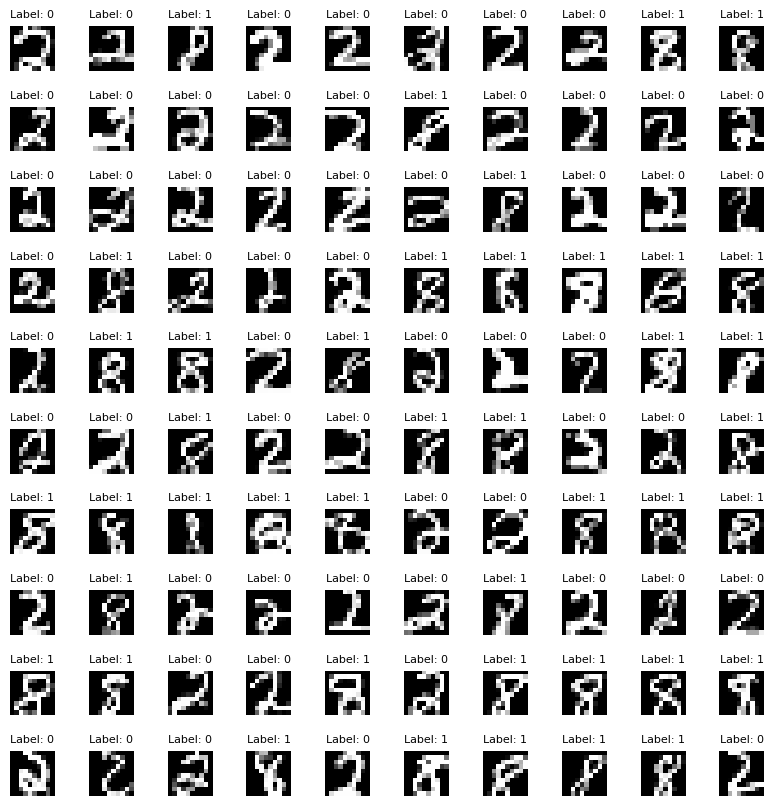

In [98]:
# 0 - 12396 images of 3 and 7 
# Matplot is used to render the image 

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
axes = axes.ravel()  # Flatten the 10x10 matrix into an array of 100 subplots

# Loop through subplots and add images
for i in range(100):
    image = train_features_shuffled[i].reshape(10, 10)  # Assuming the images are 10x10
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {train_labels_shuffled[i]}", fontsize=8)
    plt.subplots_adjust(hspace=0.8)
    axes[i].axis('off')

plt.show()

<h1>Training the Model </h1>

In [99]:
# Initialize and train the model with unshuffled data
model = LogisticRegression(solver='liblinear')
model.fit(train_features, train_labels, )

LogisticRegression(solver='liblinear')

In [100]:
predictions = model.predict(test_features)
accuracy = accuracy_score(test_labels, predictions)
print(f'Accuracy: {accuracy * 100}%')

Accuracy: 97.70687936191426%


In [101]:
# Initialize and train the model with shuffled data
subset_train_features, subset_train_labels =  train_features_shuffled[:1000], train_labels_shuffled[:1000]
subset_test_features, subset_test_labels =  test_features_shuffled[:1000], test_labels_shuffled[:1000]



model = LogisticRegression(solver='liblinear')
model.fit(subset_test_features, subset_test_labels)

LogisticRegression(solver='liblinear')

In [102]:
predictions = model.predict(test_features)
accuracy = accuracy_score(test_labels, predictions)
print(f'Accuracy: {accuracy * 100}%')

Accuracy: 97.45762711864407%


In [103]:
#Find the best parameters for the model
# Define hyperparameter grid
param_dist = {
    'C': np.logspace(-3, 3, 50),
    'penalty': ['l2'],
    'solver': ['liblinear']
}

# Initialize and configure Random Search
random_search = RandomizedSearchCV(LogisticRegression(), param_distributions=param_dist, n_iter=50, cv=5)

# Perform Random Search on the training data
random_search.fit(train_features, train_labels)

# Get the best parameters
best_params = random_search.best_params_

KeyboardInterrupt: 

In [ ]:
# Train the model
# Initialize and train the model with the best parameters
model = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver=best_params['solver'])
model.fit(train_features, train_labels)

# model.fit(train_features, train_labels)

LogisticRegression(C=0.1, solver='liblinear')

In [ ]:
predictions = model.predict(test_features)


In [ ]:
accuracy = accuracy_score(test_labels, predictions)
print(f'Accuracy: {accuracy * 100}%')


Accuracy: 97.45762711864407%


In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(test_labels, predictions))


Confusion Matrix:
[[995  37]
 [ 14 960]]


In [ ]:
print("\nClassification Report:")
print(classification_report(test_labels, predictions))



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1032
           1       0.96      0.99      0.97       974

    accuracy                           0.97      2006
   macro avg       0.97      0.97      0.97      2006
weighted avg       0.97      0.97      0.97      2006



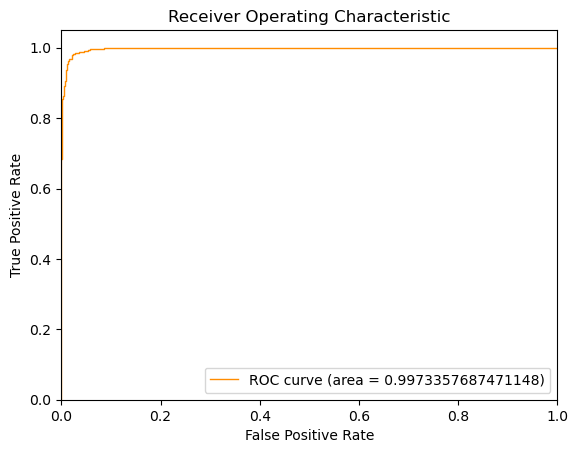

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, model.predict_proba(test_features)[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (area = {roc_auc})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

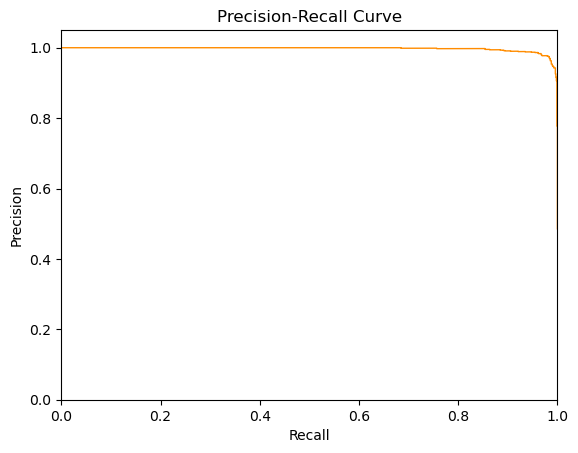

In [ ]:
# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(test_labels, model.predict_proba(test_features)[:,1])

# Plot curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

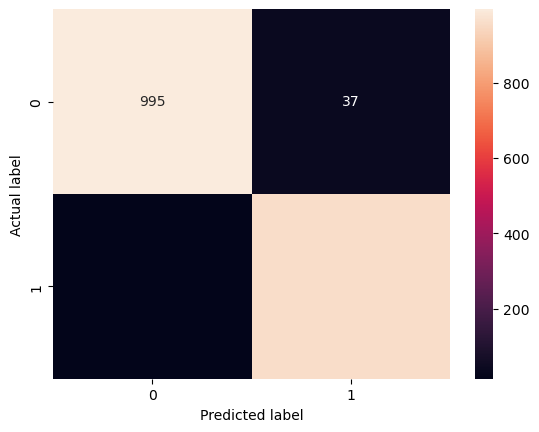

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plot as heatmap
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()
